In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt

from main import Solver
from gurobi_solver import GurobiSolver

In [2]:
solver = Solver()
gurobi = GurobiSolver('/Users/jetchung/gurobi.json')

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2471762
Academic license 2471762 - for non-commercial use only - registered to jo___@hertford.ox.ac.uk


# Notebook

In [3]:
import random
import matplotlib.pyplot as plt

def simulate_movement(balls, time_steps, step_size, size):
    # Create a deep copy of the balls list to avoid modifying the original list
    balls_copy = [ball.copy() for ball in balls]
    
    for _ in range(time_steps):
        for ball in balls_copy:
            # Randomly select direction and step size
            direction = random.choice([1, -1])
            # Update coordinates of the ball based on direction and step size
            ball[0] += direction * step_size  # Movement in x-axis
            ball[1] += direction * step_size  # Movement in y-axis
            ball[0] = max(min(ball[0], size), -size)
            ball[1] = max(min(ball[1], size), -size)
        
    return balls_copy

# Function to plot the coordinates of the balls
def plot_coordinates_subplot(balls, title, subplot_index, size):
    for idx, ball in enumerate(balls):
        plt.scatter(ball[0], ball[1], label=f"Ball {idx+1}")
    plt.xlim(-size, size)
    plt.ylim(-size, size)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(title)
    plt.grid(True)
    
    
def sql2(point1, point2):
    point1_np = np.array(point1)
    point2_np = np.array(point2)
    return np.sum((point1_np - point2_np)**2)
def normalize_matrix(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    if min_val == max_val:
        # If all values are the same, return a matrix with all entries as 50
        return np.full_like(matrix, 50)
    else:
        normalized_matrix = 100 * (matrix - min_val) / (max_val - min_val)
        return normalized_matrix

def display_mistakes(output):
    correct_count = 0
    mistake_count = 0
    for i, (x, y, z) in enumerate(output):
        if x == y == z == i:
            correct_count += 1
        else:
            mistake_count += 1
            print(f"Mistake at index {i}: Expected {(i, i, i)}, Got {(x, y, z)}")
    print(f"Correct: {correct_count}, Mistakes: {mistake_count}")

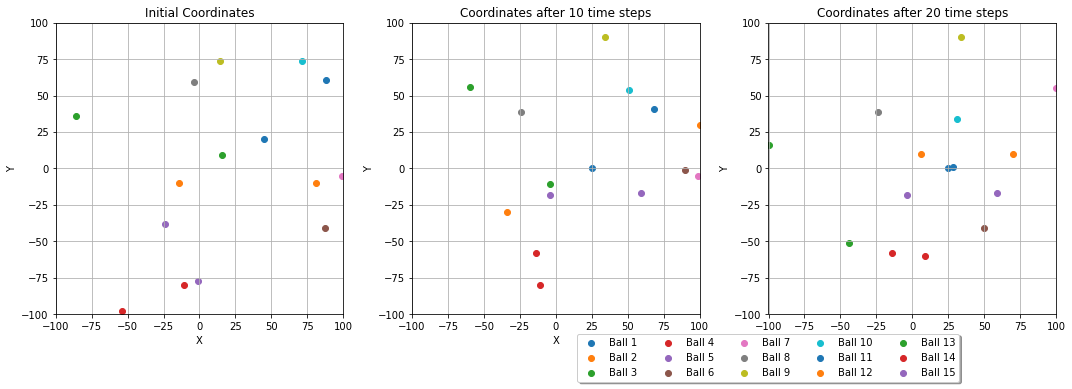

In [55]:
N = 15
step_size = 10
size = 100
D = np.zeros((N,N,N))

plt.figure(figsize=(15, 5))


balls1 = [[random.randint(-size, size), random.randint(-size, size)] for _ in range(N)]

plt.subplot(1, 3, 1)
plot_coordinates_subplot(balls1, 'Initial Coordinates', 1, size)

balls2 = simulate_movement(balls1, 10, step_size, size)

plt.subplot(1, 3, 2)
plot_coordinates_subplot(balls2, 'Coordinates after 10 time steps', 2, size)

balls3 = simulate_movement(balls2, 10, step_size, size)


plt.subplot(1, 3, 3)
plot_coordinates_subplot(balls3, 'Coordinates after 20 time steps', 3, size)

plt.tight_layout()

# Set legend centered under the second plot
plt.legend(loc='center', bbox_to_anchor=(0, -0.15), shadow=True, ncol=5)
plt.show()

for i in range(N):
    for j in range(N):
        for k in range(N):
            D[i,j,k] = sql2(balls1[i], balls2[j]) + sql2(balls2[j], balls3[k])
            
C = normalize_matrix(-D)

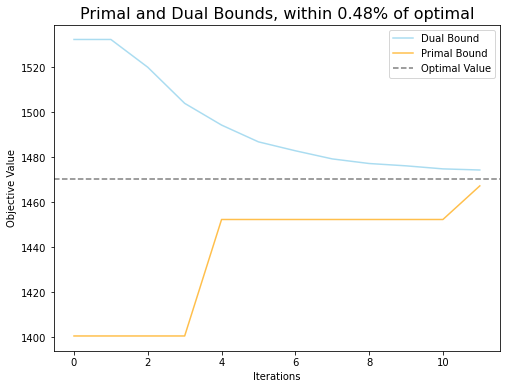

In [56]:
learning_rate_scale="constant"
algorithm="nesterov"
beta=0.95
search_size=10
learning_rate=0.1
max_iterations=1000
threshold=0.01

optimal_value, gurobi_choice = gurobi.optimize(C)

dual_bounds, primal_bounds, best_sol, best_val, _, fraction = solver.optimize(C, learning_rate_scale, algorithm, beta, search_size, learning_rate, max_iterations, threshold)
plt.figure(figsize=(8, 6))

plt.plot(dual_bounds, label='Dual Bound', color = "skyblue", alpha = 0.7)
plt.plot(primal_bounds, label = 'Primal Bound', color = "orange", alpha = 0.7)

plt.axhline(y=optimal_value, color='gray', linestyle='--', label='Optimal Value')

plt.xlabel('Iterations')
plt.ylabel('Objective Value')
plt.title(f"Primal and Dual Bounds, within {fraction * 100:.2f}% of optimal", fontsize = 16)
plt.legend()
plt.show()

In [57]:
# the coordinates should be of the form (i, i, i) 
# so we see our solution is competitive with an exact solver while faster

In [58]:
indices = np.where(best_sol == 1)
coordinates = list(zip(indices[0], indices[1], indices[2]))
coordinates

[(0, 10, 0),
 (1, 12, 14),
 (2, 2, 2),
 (3, 13, 12),
 (4, 14, 1),
 (5, 4, 5),
 (6, 6, 4),
 (7, 7, 7),
 (8, 8, 8),
 (9, 9, 9),
 (10, 11, 6),
 (11, 5, 11),
 (12, 0, 10),
 (13, 3, 3),
 (14, 1, 13)]

In [59]:
gurobi_choice

[(0, 10, 10),
 (1, 12, 1),
 (2, 2, 2),
 (3, 13, 13),
 (4, 14, 14),
 (5, 4, 5),
 (6, 6, 4),
 (7, 7, 7),
 (8, 8, 8),
 (9, 9, 9),
 (10, 11, 6),
 (11, 5, 11),
 (12, 0, 0),
 (13, 3, 3),
 (14, 1, 12)]

In [60]:
start_time = timeit.default_timer()
optimal_value, gurobi_choice = gurobi.optimize(C)
timeit.default_timer() - start_time


0.1939263489999803

In [61]:
start_time = timeit.default_timer()
dual_bounds, primal_bounds, best_sol, best_val, _, fraction = solver.optimize(C, learning_rate_scale, algorithm, beta, search_size, learning_rate, max_iterations, threshold)
timeit.default_timer() - start_time

0.010367793000000347